# Qamomile クイックスタートガイド

このガイドでは、Qamomile のインストール方法と基本的な使い方を簡単に紹介します。

## インストール

### 前提条件

Qamomile をインストールする前に、以下の環境が整っていることを確認してください：

- Python 3.10 以上
- pip（Python パッケージインストーラ）

### Qamomile のインストール

pip を使って Qamomile をインストールします：

```bash
pip install qamomile
```

### オプションの依存パッケージ

利用目的に応じて、以下の追加パッケージをインストールすることができます：

- Qiskit との連携用：`pip install "qamomile[qiskit]"`
- Quri Parts との連携用：`pip install "qamomile[quri-parts]"`
- Qutip との連携用：`pip install "qamomile[qutip]"`
- PennyLane との連携用：`pip install "qamomile[pennylane]"`

## 基本的な使い方

簡単な例を通して、Qamomile の使用方法を見ていきましょう。

### 1. Qamomile と JijModeling のインポート

In [1]:
import qamomile.core as qm
import jijmodeling as jm
import jijmodeling_transpiler.core as jmt
import ommx.v1

### 2. JijModeling を使って数理モデルを作成する

In [2]:
# 単純なQUBO問題を定義する

Q = jm.Placeholder("Q", ndim=2)
n = Q.len_at(0, latex="n")
x = jm.BinaryVar("x", shape=(n,))

problem = jm.Problem("qubo")
i, j = jm.Element("i", n), jm.Element("j", n)
problem += jm.sum([i, j], Q[i, j] * x[i] * x[j])

problem

In [3]:
# データを用意する
instance_data = {
    "Q": [[0.1, 0.2, -0.1],
          [0.2, 0.3, 0.4],
          [-0.1, 0.4, 0.0]]
}

# 問題をコンパイルする:
# データを問題へと代入する
interpreter = jm.Interpreter(instance_data)
instance: ommx.v1.Instance = interpreter.eval_problem(problem)

### 3. Qamomile を使って量子回路とハミルトニアンを作成する

In [4]:
qaoa_converter = qm.qaoa.QAOAConverter(instance)

# イジングハミルトニアンへとエンコードする
qaoa_converter.ising_encode()

# QAOAの量子回路を取得する
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=2)
# 損失ハミルトニアンを取得する
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

### 4. 量子計算 SDK（Qiskit または Quri Parts）へのトランスパイル  
この例では Qiskit を使用します。

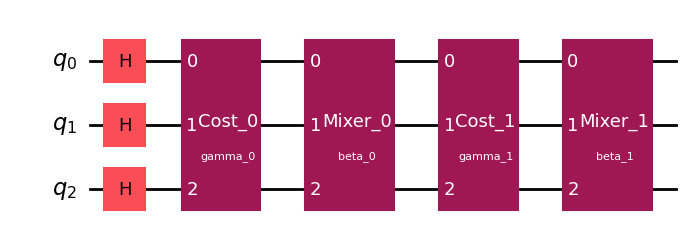

In [5]:
import qamomile.qiskit as qm_qk

qk_transpiler = qm_qk.QiskitTranspiler()

# QAOA量子回路をQiskit形式へと変換する
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_circuit.draw(output="mpl")

In [6]:
# QAOAハミルトニアンをQiskit形式へと変換する
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)
qk_hamiltonian

SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI', 'III'],
              coeffs=[-0.1 +0.j, -0.45+0.j, -0.15+0.j,  0.1 +0.j, -0.05+0.j,  0.2 +0.j,
  0.45+0.j])

### 5. 量子回路の実行

量子回路を量子シミュレータまたは実際の量子コンピュータ上で実行します。  
この例では Qiskit を使用します。

Qamomile では、量子回路の実行は各 SDK に委ねられており、ユーザーが自分で実装できるようになっています。現在の量子コンピュータの主な用途が研究や教育であることを踏まえると、量子最適化アルゴリズムを実行する多くのケースがこれらの分野に該当すると考えられます。Qamomile がブラックボックス化するのを避けるため、量子回路の実行部分はユーザーに任せており、アルゴリズムのカスタマイズを容易にしています。

In [7]:
import qiskit.primitives as qk_pr
import numpy as np
from scipy.optimize import minimize

cost_history = []
def cost_estimator(param_values):
    estimator = qk_pr.StatevectorEstimator()
    job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
    result = job.result()[0]
    cost = result.data['evs']
    cost_history.append(cost)
    return cost

# QAOAオプティマイザーを実行する
result = minimize(
    cost_estimator,
    [np.pi / 4, np.pi / 2, np.pi / 2, np.pi / 4],
    method="COBYLA",
    options={"maxiter": 1000},
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.02175724764529785
       x: [ 8.003e-01  1.940e+00  1.020e+00  1.508e+00]
    nfev: 310
   maxcv: 0.0


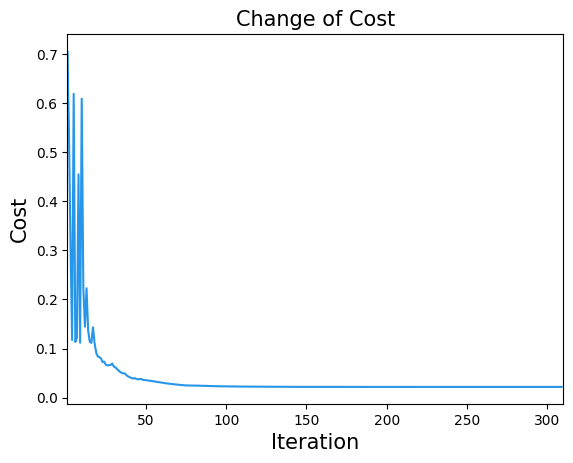

In [8]:
import matplotlib.pyplot as plt

plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

In [9]:
# 最適化されたQAOAを実行する
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=1000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]
qaoa_counts.get_counts()

{'000': 593, '100': 135, '001': 235, '101': 36, '111': 1}

### 6. 結果のデコード

量子回路を実行した後、得られた結果をデコードして解を取得します。

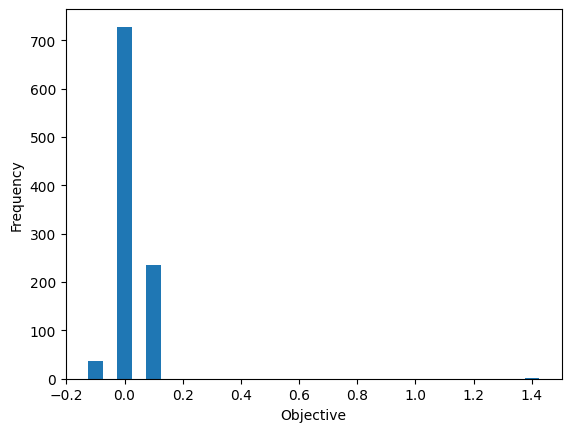

In [10]:
from collections import defaultdict
import matplotlib.pyplot as plt

sampleset: ommx.v1.SampleSet = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])

# 各エネルギー値の出現回数を蓄積するための辞書を初期化する
frequencies = defaultdict(int)

# エネルギー値を丸める際の精度を定義する
for energy in sampleset.objectives.values():
    rounded_energy = round(energy, ndigits = 3)  
    frequencies[rounded_energy] += 1

plt.bar(frequencies.keys(), frequencies.values(), width=0.05)
plt.xlabel('Objective')
plt.ylabel('Frequency')
plt.show()
